# Front Matter: CASA0013: Foundations of Spatial Data Science

## Title of Briefing

### Student ID: 21053585

### Word Count:

# Reproducible Analysis

Please feel free to add as many code cells and markdown cells of comment/explanation as needed to make your code legible and clear. Your code should output any figures needed to disk.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

/home/shiraozhang/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
## Borough Boundaries
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

/home/shiraozhang/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
## Load the InsideAirbnb data into a DataFrame.
cols = ['id','name','price','latitude','longitude','room_type']
df = pd.read_csv(os.path.join('data','raw','listings.csv'), usecols=cols, low_memory=False)

In [4]:
## Clean the data
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
# print(df.shape)

In [5]:
## Convert the df into a GeoDataFrame named gdf
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

In [6]:
## Associate LA (Local Authority) names to the listings using a spatial join
gdf_la = gpd.sjoin(gdf, boros, op='within', how='left')
# print(gdf_la.columns.values)
# print(gdf_la.shape)
# gdf_la.sample(3, random_state=42)[['id','name','NAME']]

In [7]:
## Tidy Up the data
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
# gdf_la.NAME.unique()

In [8]:
# gdf[gdf_la.NAME.isna()][['id','name']]

<AxesSubplot:>

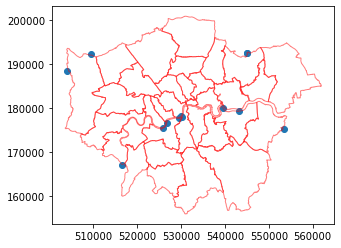

In [9]:
## Map Problematic Listings
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

In [10]:
## Drop Problematic Results
gdf_la.drop(index=gdf[gdf_la.NAME.isna()].index, axis=1, inplace=True)
# print(gdf_la.shape)

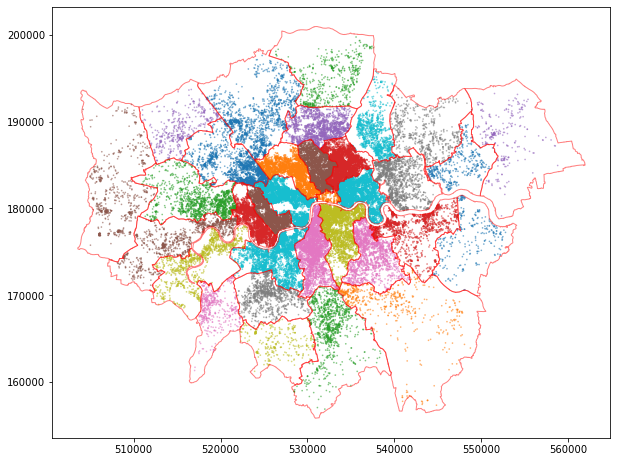

In [11]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

(0.0, 500.0)

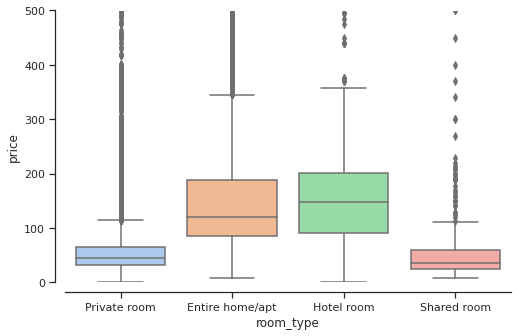

In [12]:
## A Basic Boxplot
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))
sns.boxplot(y=gdf_la.price, x=gdf_la.room_type)
sns.despine(offset=10)
ax.set_ylim([0,500])

In [13]:
## group the data on the LA name
la_data = gdf_la.groupby(['NAME'])
# print(type(la_data))
la_data.price.mean()

NAME
Barking and Dagenham       76.228205
Barnet                    132.546179
Bexley                     67.400735
Brent                     125.470126
Bromley                    79.077206
Camden                    156.792000
City of London            239.709859
Croydon                    67.545024
Ealing                     91.325301
Enfield                    72.527145
Greenwich                 136.151123
Hackney                   103.761831
Hammersmith and Fulham    141.707237
Haringey                   96.056055
Harrow                     77.497674
Havering                   83.254902
Hillingdon                 92.024348
Hounslow                  111.594130
Islington                 142.608873
Kensington and Chelsea    209.966158
Kingston upon Thames      103.713115
Lambeth                   101.273781
Lewisham                   90.135135
Merton                    121.448683
Newham                     91.283489
Redbridge                  79.078049
Richmond upon Thames      137.209

In [14]:
## create a data frame grouped by LA and room type
la_data2 = gdf_la.groupby(['NAME','room_type']).agg(
    {'price':['count','sum','mean','median','std',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]}
).reset_index()

In [15]:
## convert the above to a flat index
la_data2.columns = la_data2.columns.droplevel(0)
# print(la_data2.columns.values)

In [16]:
## correct a few column labels
cols = la_data2.columns.values
cols[ 0] = 'name'
cols[ 1] = 'room_type'
cols[-2] = 'lq'
cols[-1] = 'uq'
la_data2.columns = cols

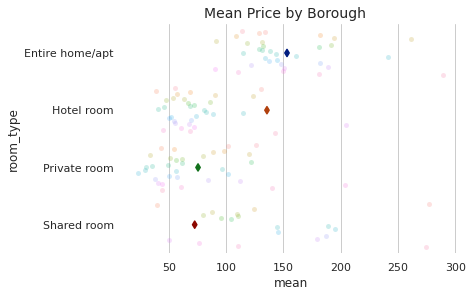

In [17]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

## Show each observation with a scatterplot
## https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="mean", y="room_type", hue="name",
              data=la_data2, dodge=True, alpha=.25, zorder=1)
g.legend_.remove()

## Show the mean of means
sns.pointplot(x="mean", y="room_type",
              data=la_data2.groupby('room_type').agg('mean').reset_index(), 
              dodge=.232, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

plt.gcf().subplots_adjust(top=0.92)
f.suptitle('Mean Price by Borough', fontsize=14);

In [18]:
## Grouping on a Custom Mapping
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
# print(len(mapping.keys()))

In [19]:
## Group by your mapping and by room_type
la_data3 = gdf_la.set_index('NAME').groupby([mapping,'room_type']).agg(
    {'price':['mean','median']}
).reset_index()

In [20]:
## convert the above to a flat index
la_data3.columns = la_data3.columns.droplevel(0)
cols = la_data3.columns.values
cols[0]  = 'area'
cols[1]  = 'room_type'
la_data3.columns = cols

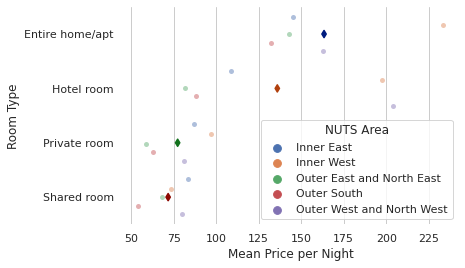

In [21]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

## Show each observation with a scatterplot
## https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="mean", y="room_type", hue="area",
              data=la_data3, dodge=True, alpha=.45, zorder=1)
g.legend_.set_title('NUTS Area')

## Show the mean of means
sns.pointplot(x="mean", y="room_type",
              data=la_data3.groupby('room_type').agg('mean').reset_index(), 
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)

## set the plot x- and y-labels...
plt.xlabel('Mean Price per Night')
plt.ylabel('Room Type');

# Executive Briefing

This should be composed of markdown cells _only_. You may have more than one markdown cell so as to support a useful Table of Contents. Images should be included by reference using the standard Markdown format `![Alt text here](local/image/created_in_code.png)`. 
<br>
Add each section of your briefing to the corresponding cell below. 
<br>
_Additional guidence on the structure can be found on Moodle_


## Executive summary


## Background

## Data Analysis

## Conclusion

# Bibliography

This should be a list in markdown of any documents referenced in the _Executive Briefing_. Please also link to the document using the standard Markdown format `[Link text](https://link.website.org/)`. If the document is an academic article or other piece requiring authentication please link to a DOI.
